In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math


# Context

Целью данной работы является анализ признаков и их взаимосвязей в  наборе данных о пассажирах Титаника, с целью выявления признаков, определяющих наибольшую вероятность на выживание.

In [2]:
data_train = pd.read_csv('train.csv' )

In [3]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


#### Описание признаков датасета

Мы видим таблицу со следующими признаками:
* PassengerId — идентификатор пассажира;
* Survived — выжил ли пассажир;
* Pclass — класс пассажира (1 — высший, 2 — средний, 3 — низший);
* Name — имя пассажира;
* Sex — пол пассажира;
* Age — возраст пассажира;
* SibSp — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника;
* Parch — количество родителей, детей (в том числе приемных) на борту Титаника;
* Ticket — номер билета;
* Fare — плата за проезд;
* Cabin — каюта;
* Embarked — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон)

In [4]:
print(f'Количество строк: {data_train.shape[0]}') 
print(f'Количество столбцов: {data_train.shape[1]}')

Количество строк: 100000
Количество столбцов: 12


In [5]:
sns.set_style('darkgrid')

# Data quality assessment

В данном разделе мы осуществим  анализ и чистку переменных данного датасета.

#### Рассмотрим описательную статистику

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


#### Проверяем данные на наличие дубликатов

In [7]:
print(f'Количество дубликатов: {data_train.duplicated().sum()}')

Количество дубликатов: 0


#### Изучим данные на наличие уникальных значений

In [8]:
for col in data_train.columns:
    print(f'{col}: unique values: {len(data_train[col].unique())}' )

PassengerId: unique values: 100000
Survived: unique values: 2
Pclass: unique values: 3
Name: unique values: 92144
Sex: unique values: 2
Age: unique values: 174
SibSp: unique values: 7
Parch: unique values: 8
Ticket: unique values: 75332
Fare: unique values: 15936
Cabin: unique values: 26993
Embarked: unique values: 4


На основании полученных данных можно сделать вывод, что данный датасет содержит 4 количественные переменные ('Age' и 'Fare') и 8 категориальных (признак 'Survived' так же является целевым признаком). Так же можно отметить, что колонки с идентификатором пассажира ('PassengerId'), именем пассажира('Name') и номером билета('Ticket') является уникальными для всех и не представляют ценности для дальнейшего анализа. Данные колонки можно удалить.

In [9]:
useless_columns = ['Name', 'Ticket','PassengerId']
data_train = data_train.drop(columns=useless_columns)

In [10]:
data_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,1,male,NaN,2,0,27.14,C12239,S
1,0,3,male,NaN,0,0,13.35,NaN,S
2,0,3,male,0.33,1,2,71.29,NaN,S
3,0,3,male,19.00,0,0,13.04,NaN,S
4,1,3,male,25.00,0,0,7.76,NaN,S


#### Произведем обнаружение отсутствующих данных в наборе с помощью тепловой карты и процентного списка

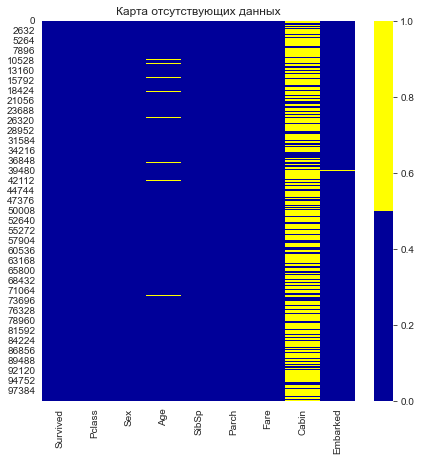

In [11]:
plt.figure(figsize=(7,7))
colours =['#000099','#ffff00']
sns.heatmap(data_train.isnull(), cmap=sns.color_palette(colours))
plt.title('Карта отсутствующих данных')
plt.show()

Процентный список пропущенных данных

In [12]:
for col in data_train.columns:
    print('{} - {} %'.format(col, np.mean(data_train[col].isnull()*100)))


Survived - 0.0 %
Pclass - 0.0 %
Sex - 0.0 %
Age - 3.292 %
SibSp - 0.0 %
Parch - 0.0 %
Fare - 0.134 %
Cabin - 67.866 %
Embarked - 0.25 %


Мы наблюдаем, что в данном датасете имеются пропущенные значения в признаках: 'Age','Fare','Cabin','Embarked'.

#### Для дальнейшего анализа рассмотрим  каждый  признак более подробно. 

#### Количественные переменные

Проанализируем основные показатели по количественным переменным.

In [13]:
data_train[['Age','SibSp','Parch','Fare']].describe()

,Age,SibSp,Parch,Fare
count,96708.000000,100000.000000,100000.000000,99866.00000
mean,38.355472,0.397690,0.454560,43.92933
std,18.313556,0.862566,0.950076,69.58882
min,0.080000,0.000000,0.000000,0.68000
25%,25.000000,0.000000,0.000000,10.04000
50%,39.000000,0.000000,0.000000,24.46000
75%,53.000000,1.000000,1.000000,33.50000
max,87.000000,8.000000,9.000000,744.66000


В признаках 'Age' и 'Fare' отсутствие данных составляет 3.3% и 0.13%, что является не существенным на данном объеме данных. В результате можно воспользоваться методом принудительного заполнения пропусков. Для этого проанализируем зависимость цены билета и возраста от класса пассажира.

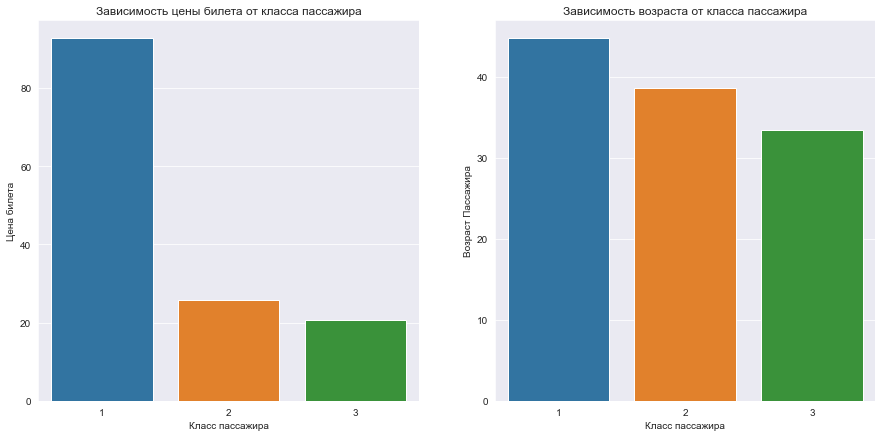

In [14]:
fig,axes = plt.subplots(1,2, sharex='all',figsize=(15,7))
sns.barplot(x='Pclass',y='Fare',data=data_train,ax=axes[0], ci = None).set_title('Зависимость цены билета от класса пассажира')
sns.barplot(x='Pclass',y='Age',data=data_train,ax=axes[1], ci = None).set_title('Зависимость возраста от класса пассажира')
axes[0].set(xlabel='Класс пассажира', ylabel='Цена билета')
axes[1].set(xlabel='Класс пассажира', ylabel='Возраст Пассажира');
plt.show()

На основании графиков можно сделать вывод, что пропуски в цене билета и возрасте лучше заменить средним значением от класса  которым плывет пассажир.

In [15]:
data_train['Age'] = data_train.groupby('Pclass')['Age'].transform(lambda group: group.fillna(group.mean()))
data_train['Fare'] = data_train.groupby('Pclass')['Fare'].transform(lambda group: group.fillna(group.mean()))

In [16]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Sex       100000 non-null  object 
 3   Age       100000 non-null  float64
 4   SibSp     100000 non-null  int64  
 5   Parch     100000 non-null  int64  
 6   Fare      100000 non-null  float64
 7   Cabin     32134 non-null   object 
 8   Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 6.9+ MB


Для удобства округлим значения возраста до полных лет 

In [17]:
data_train['Age'] = data_train['Age'].apply(lambda x: math.floor(x))

Для выделения выбросов в количественных признаках построим разновидность графика " ящик с усами ".

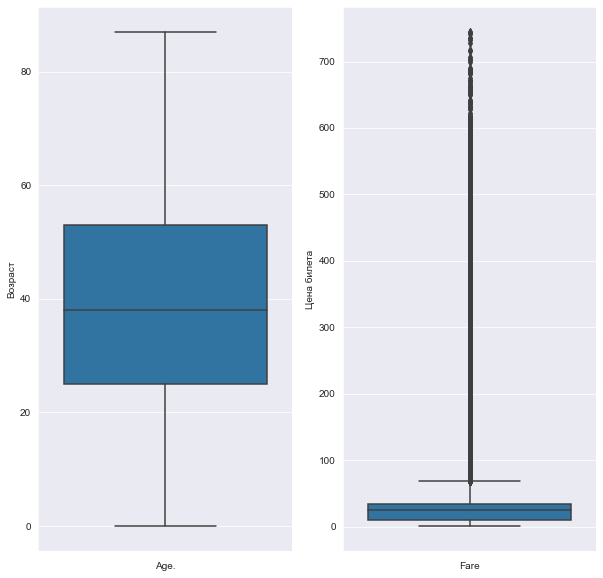

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
sns.boxplot(y = data_train['Age'], data=data_train, ax=ax[0])
sns.boxplot(y = data_train['Fare'], data=data_train, ax=ax[1])
ax[0].set(xlabel='Age.', ylabel='Возраст')
ax[1].set(xlabel='Fare', ylabel='Цена билета');
plt.show()

На основании построенных графиков мы можем сделать следующий вывод:
* В признаке 'Age' отсутствуют выбросы. Так же можно сказать, что большая часть пассажиров приходится на возраст с 20 до 60 лет. Среднее значение возраста составляет 38 лет;
* В признаке 'Fare' присутствует существенное количество "верхних" выбросов.

Занесем в отдельный датасет всех пассажиров у которых цена билета находится в пределах "верхних" выбросов.

In [19]:
q = data_train["Fare"].quantile(0.75) + 1.5*(data_train["Fare"].quantile(0.75)-data_train["Fare"].quantile(0.25))
data_blowout=data_train[data_train["Fare"] > q]

Рассмотрим присутствует ли зависимость между наличием выбросов от признаков которые могут повлиять на цену билета. К таким признакам относятся: 'Pclass' (класс которым плывет пассажир) и ‘Embarked' (порт, где садился пассажир, так как в разных портах могли быть разные цены на билеты).

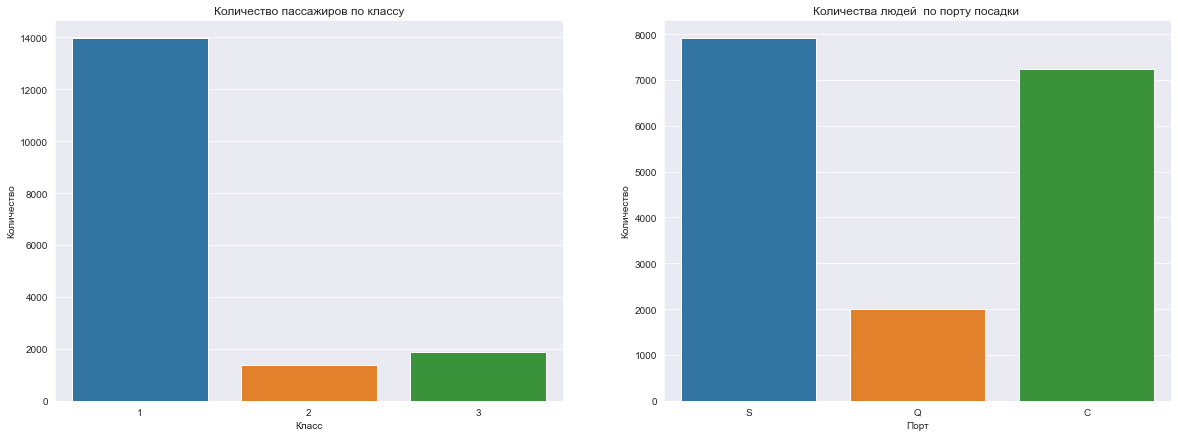

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
sns.countplot(x=data_blowout['Pclass'], ax=ax[0]).set_title("Количество пассажиров по классу")
ax[0].set(xlabel='Класс', ylabel='Количество')
sns.countplot(x=data_blowout['Embarked'], ax=ax[1]).set_title("Количества людей  по порту посадки ")
ax[1].set(xlabel='Порт', ylabel='Количество')
plt.show()

На основании графиков можно сказать, что основное количество выбросов приходится на пассажиров 1 класса которые садились на корабль в порту Шербур(C) и Саутгемптон(S). Данные выбросы мы оставляем в датасете, так как они могут быть правдивыми.

Рассмотрим признаки 'SibSp' и 'Parch'. Данные признаки не имеют пропусков данных.

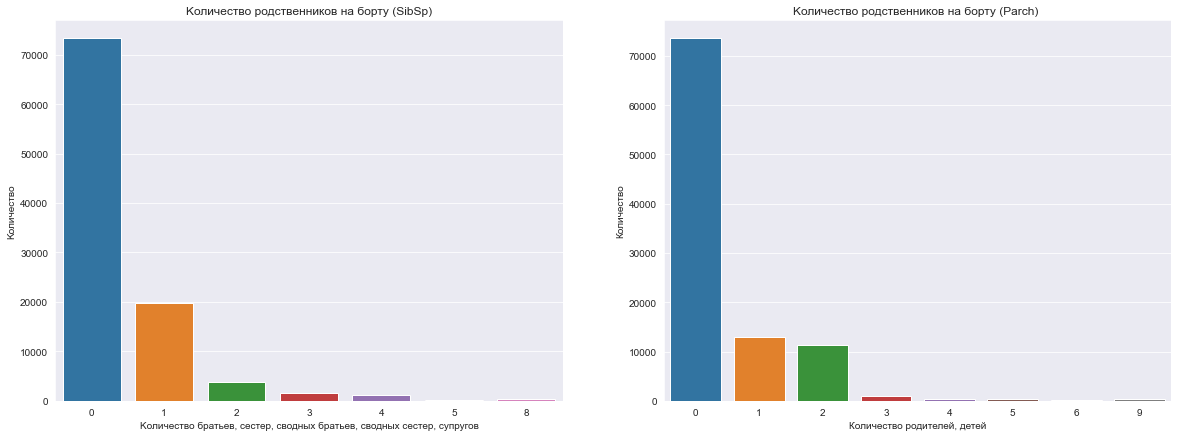

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
sns.countplot(x=data_train['SibSp'], ax=ax[0]).set_title("Kоличество родственников на борту (SibSp)")
ax[0].set(xlabel='Kоличество братьев, сестер, сводных братьев, сводных сестер, супругов', ylabel='Kоличество')
sns.countplot(x=data_train['Parch'], ax=ax[1]).set_title("Kоличество родственников на борту (Parch) ")
ax[1].set(xlabel='Количество родителей, детей', ylabel='Количество')
plt.show()

На данных графиках мы видим скошенные распределения. Количество пассажиров, у которых не было родственников на борту составляет более 70%. Это приводит к дисбалансу классов, что может отрицательно сказаться на обучающую модель. Для снижения дисбаланса создадим переменную 'Family' со значениями:
* 0: пассажир плывет один на корабле, если значения переменных SibSp и Parch дают в сумме 0;
* 1: пассажир плывет c родственниками, в остальных случаях.


In [22]:
data_train.loc[:, 'Family'] = np.where((data_train.Parch>0) | (data_train.SibSp>0), 1, 0)

In [23]:
data_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family
0,1,1,male,44,2,0,27.14,C12239,S,1
1,0,3,male,33,0,0,13.35,NaN,S,0
2,0,3,male,0,1,2,71.29,NaN,S,1
3,0,3,male,19,0,0,13.04,NaN,S,0
4,1,3,male,25,0,0,7.76,NaN,S,0


В результате мы получили новый категориальный признак 'Family'. Посмотрим как изменился дисбаланс классов.

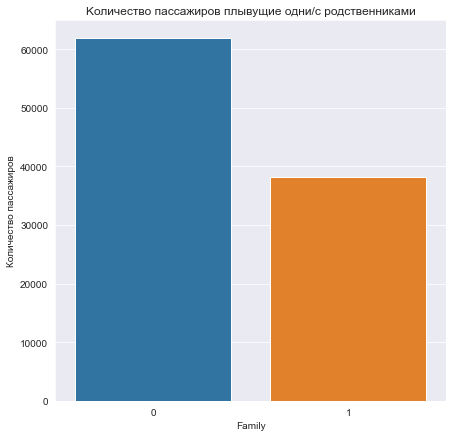

In [63]:
plt.figure (figsize = (7,7))
sns.countplot(x=data_train['Family']).set_title("Kоличество пассажиров плывущие одни/с родственниками")
plt.ylabel("Количество пассажиров")
plt.show()

In [25]:
data_train['Family'].value_counts(normalize=True)

0    0.61853
1    0.38147
Name: Family, dtype: float64

На основании графика мы можем сказать, что у нас получилось снизить дисбаланс классов. Отношение пассажиров плывущих без родственников к пассажирам с родствениками составляет 0.61 к 0.38.

#### Категориальные переменные

В признаке 'Cabin' отсутствие данных составляет 67%, что является существенным пропуском данных. В таком случае считается лучше удалить всю колонку, так как пропуск слишком высок для использования данных в анализе. Однако, для интереса, проверим существует ли взаимосвязь между наличием данных о каюте и выживших пассажиров.


In [26]:
data_train['Survived'].groupby(data_train['Cabin'].isnull()).mean()

Cabin
False    0.608608
True     0.342101
Name: Survived, dtype: float64

Мы можем наблюдать что, пассажиры чьи данные о каюте отсутствовали выжили в 34% случае, а у которых данные присутствовали выжили в 61% случае. Тем самым мы можем говорить о наличии взаимосвязи между признаком каюта и целевым признаком выживание. В результате мы заменим признак каюты на бинарный признак, который будет отображать есть ли у пассажира данные о каюте или нет.

In [27]:
data_train['Cabin']=np.where(data_train['Cabin'].isnull(),0,1)

In [28]:
data_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family
0,1,1,male,44,2,0,27.14,1,S,1
1,0,3,male,33,0,0,13.35,0,S,0
2,0,3,male,0,1,2,71.29,0,S,1
3,0,3,male,19,0,0,13.04,0,S,0
4,1,3,male,25,0,0,7.76,0,S,0


В признаке 'Embarked' отсутствие данных составляет 0.25%. В связи с минимальным пропуском предлагаю заменить пропущенные значения на порт, в котором садились наибольшее число пассажиров. Для этого построим диаграмму распределения количества людей  по порту посадки.

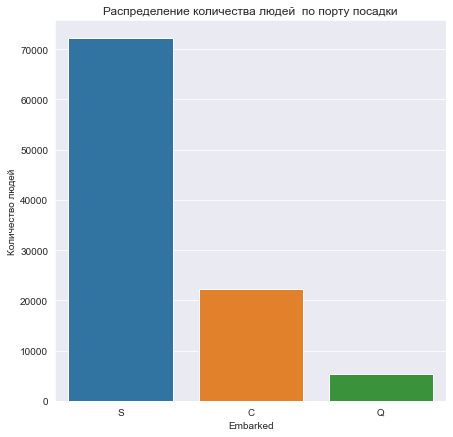

In [29]:
plt.figure (figsize = (7,7))
sns.countplot(x='Embarked',data=data_train).set_title('Распределение количества людей  по порту посадки')
plt.ylabel("Количество людей")
plt.show()

На основании полученной диаграммы мы можем наблюдать, что наибольшее число пассажиров садилось в порту Саутгемптон(S). Данным значение мы заполним наши пропуски. Так же мы видим, что по данному признаку тоже наблюдается дисбаланс классов. Пассажиров садившихся в порту Саутгемптон(S) более 70%, а пассажиров садившихся в порту Квинстаун(Q) менее 10%.


In [30]:
data_train['Embarked'] = data_train['Embarked'].fillna('S')

In [31]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Sex       100000 non-null  object 
 3   Age       100000 non-null  int64  
 4   SibSp     100000 non-null  int64  
 5   Parch     100000 non-null  int64  
 6   Fare      100000 non-null  float64
 7   Cabin     100000 non-null  int32  
 8   Embarked  100000 non-null  object 
 9   Family    100000 non-null  int32  
dtypes: float64(1), int32(2), int64(5), object(2)
memory usage: 6.9+ MB


На данном этапе мы полностью избавились от пропущенных значений в данном датасете.

Рассмотрим признаки с небольшим количеством категорий, таки как: Survived, Pclass, Sex.

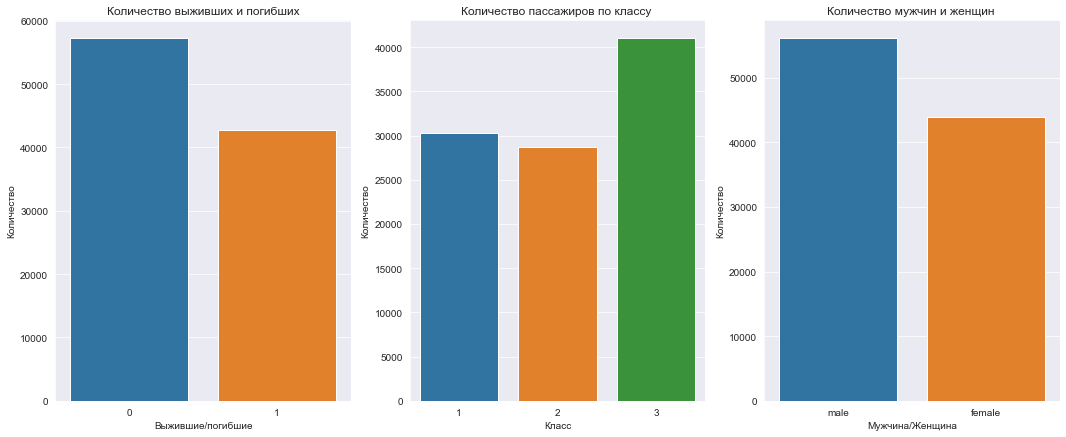

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(18,7))
sns.countplot(x=data_train['Survived'], ax=ax[0]).set_title("Количество выживших и погибших")
ax[0].set(xlabel='Выжившие/погибшие', ylabel='Количество')
sns.countplot(x=data_train['Pclass'], ax=ax[1]).set_title("Количество пассажиров по классу ")
ax[1].set(xlabel='Класс', ylabel='Количество')
sns.countplot(x=data_train['Sex'], ax=ax[2]).set_title("Количество мужчин и женщин ")
ax[2].set(xlabel='Мужчина/Женщина', ylabel='Количество');
plt.show()

In [33]:
print('% Всего выживших пассажиров', data_train['Survived'].value_counts(normalize=True)[1]*100)
print('% Всего погибших пассажиров', data_train['Survived'].value_counts(normalize=True)[0]*100)

% Всего выживших пассажиров 42.774
% Всего погибших пассажиров 57.226


По данным признакам наблюдается относительно равномерное распределение между категориями. По целевому признаку мы видим, что количество выживших пассажиров составляет 42.77%, погибших - 57.23%.

Для того, чтобы иметь возможность сразу работать с полом 'Sex', перекодируем признак в бинарное значение 0,1.

In [34]:
sex = {'male' : 0, 'female' : 1}
data_train['Sex']=data_train['Sex'].map(sex)

In [35]:
data_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family
0,1,1,0,44,2,0,27.14,1,S,1
1,0,3,0,33,0,0,13.35,0,S,0
2,0,3,0,0,1,2,71.29,0,S,1
3,0,3,0,19,0,0,13.04,0,S,0
4,1,3,0,25,0,0,7.76,0,S,0


# Data exploration

В данном разделе установим взаимосвязь между целевым признаком 'Survived' от других признаков в данном датасете.

#### Количественные переменные.

Рассмотрим взаимосвязь между признаком возраст пассажира 'Age' и целевым признаком 'Survived'.

In [36]:
data_train.groupby('Survived')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,57226.0,36.697428,17.531439,0.0,24.0,36.0,51.0,83.0
1,42774.0,40.506382,18.466163,0.0,27.0,43.0,55.0,87.0


На основании данных мы видим, что для выживших пассажиров средний возраст составляет 40.5, а для пассажиров которые не выжили 36,69.



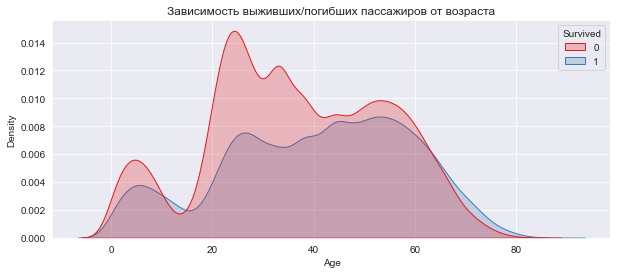

In [37]:
plt.figure(figsize=(10,4))
sns.kdeplot(x='Age',data=data_train, hue='Survived', shade=True, palette="Set1" ).set_title("Зависимость выживших/погибших пассажиров от возраста")
plt.show()


Из графика видно, что наименьшая вероятность выжить на борту была у пассажиров в возрастном диапазоне от 20 до 40 лет. Соотношение выживших и погибших пассажиров от 40 лет примерно одинаковое. Так же можно отметить, что у детей в возрасте от 0 до 10 лет вероятность выжить незначительно меньше. Рассмотрим распределение пассажиров по возрасту и полу и каким классом данные пассажиры плыли. 

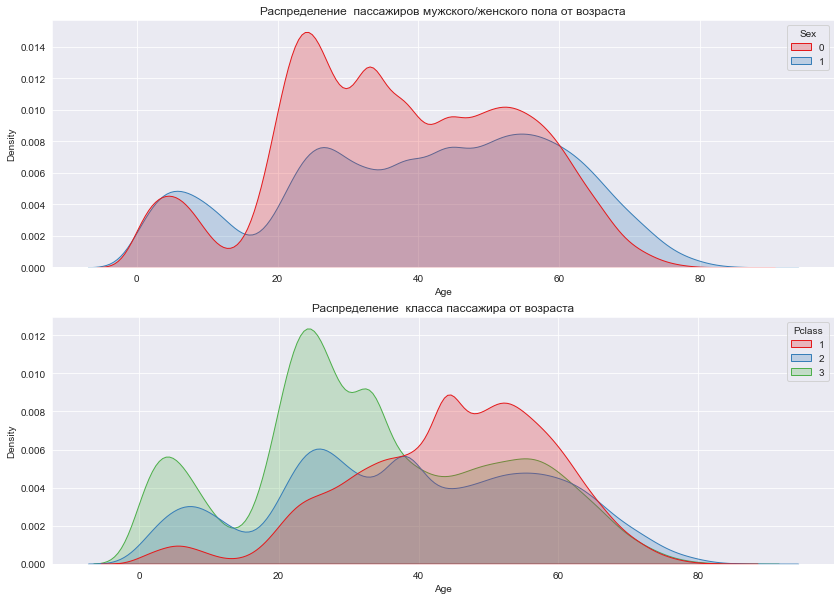

In [38]:
fig, ax =plt.subplots(2,1,figsize=(14,10))
sns.kdeplot(x='Age',data=data_train, hue='Sex', shade=True, palette="Set1", ax=ax[0]).set_title("Распределение  пассажиров мужского/женского пола от возраста")

sns.kdeplot(x='Age',data=data_train, hue='Pclass', shade=True, palette="Set1", ax=ax[1]).set_title("Распределение  класса пассажира от возраста")
plt.show()

Мы видим, что распределение пассажиров по полу и возрасту имеет сходство с распределение выживших/погибших пассажиров от возраста. Мы наблюдаем, что в возрастном диапазоне от 20 до 40 лет преобладают пассажиры мужского пола. Из графика распределения по возрастам среди различных классов видно, что доля пассажиров в возрасте от 20-40 лет преобладает в 3 классе, и наиболее низкая в 1 классе. Так же наблюдается, что доля пассажиров старше 40 лет преобладает в 1 классе по сравнению с остальными.

На основании данных графиков мы можем, сделать некоторые выводы по отношению к целевому признаку:
* вероятность спастись наименьшая у пассажиров мужского пола плывших 3 классом в возрасте от 20 до 40 лет;
* у дети в возрасте от 0 до 10 лет плывшими 3 классом вероятность выжить незначительно меньше.


Рассмотрим взаимосвязь между признаком цены билета 'Fare' и целевым признаком 'Survived'.

In [39]:
data_train.groupby('Survived')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,57226.0,32.654017,54.443718,0.68,9.16,13.08,29.72,732.01
1,42774.0,59.013601,83.344476,1.41,13.31,28.61,67.98,744.66


На основании данных мы видим, что для выживших пассажиров средняя цена билета составляет 59.01, а для пассажиров которые не выжили 32.65.

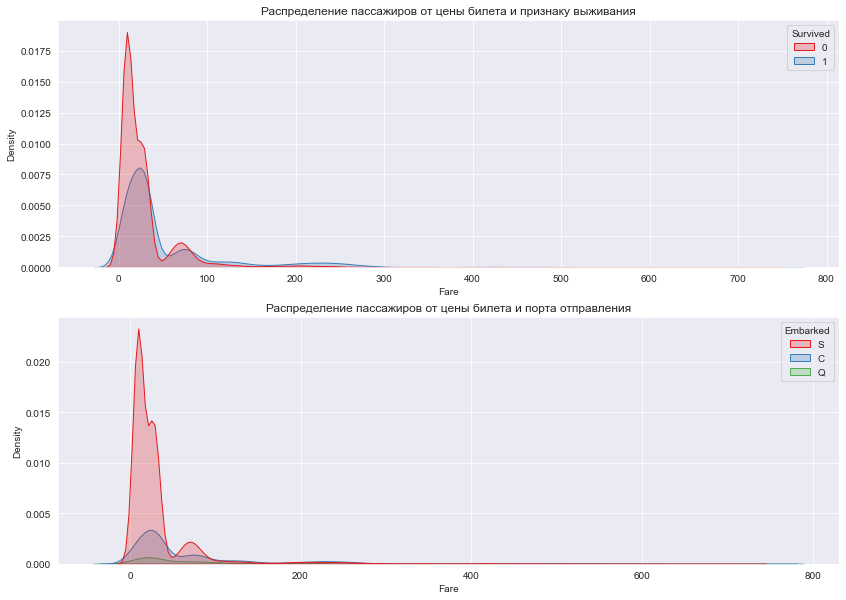

In [40]:
fig, ax =plt.subplots(2,1,figsize=(14,10))
sns.kdeplot(x='Fare',data=data_train, hue='Survived', shade=True, palette="Set1", ax=ax[0]).set_title("Распределение пассажиров от цены билета и признаку выживания")
sns.kdeplot(x='Fare',data=data_train, hue='Embarked', shade=True, palette="Set1", ax=ax[1]).set_title("Распределение пассажиров от цены билета и порта отправления")
plt.show()

<Figure size 720x288 with 0 Axes>

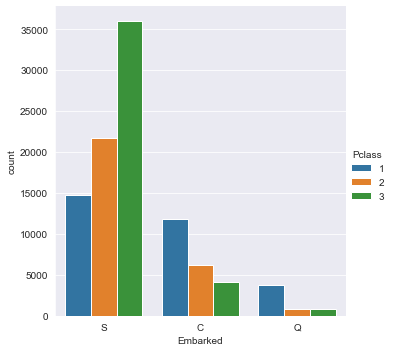

In [41]:
plt.figure(figsize=(10,4))
sns.catplot(x="Embarked", hue="Pclass", kind="count" ,data=data_train)
plt.show()

Мы наблюдаем наличие взаимосвязи между ценой билета и вероятностью выживания. В диапазоне цены от 5 до 13 вероятность выживания значительно ниже, но при увеличении цены вероятность выживания значительно увеличивается. Тем самым мы можем сказать, что рост цены положительно сказывается на выживание пассажира. Как мы наблюдали из прошлых графиков, наибольшая цена билета принадлежит пассажирам 1 класса. Следовательно вероятность выжить для пассажиров плывущим 1 классом горазда выше. Так же присутствует взаимосвязь между ценой билета и портом отправления. Наибольшее количество пассажиров с дешевыми билетами садились в порту Саутгемптон(S), где преобладают пассажиры 3 класса.

#### Категориальные переменные

Построим график взаимосвязи между категориальными переменными и целевым признаком. 

При рассмотрении категориальных переменных в предыдущем разделе мы выяснили, что переменные 'SibSp' и 'Parch' могут отрицательно сказаться на обучающую модель. Поэтому в данном разделе он использоваться не будем. Поэтому мы создали категориальную переменную ‘Family’, которую рассмотрим вместо них.

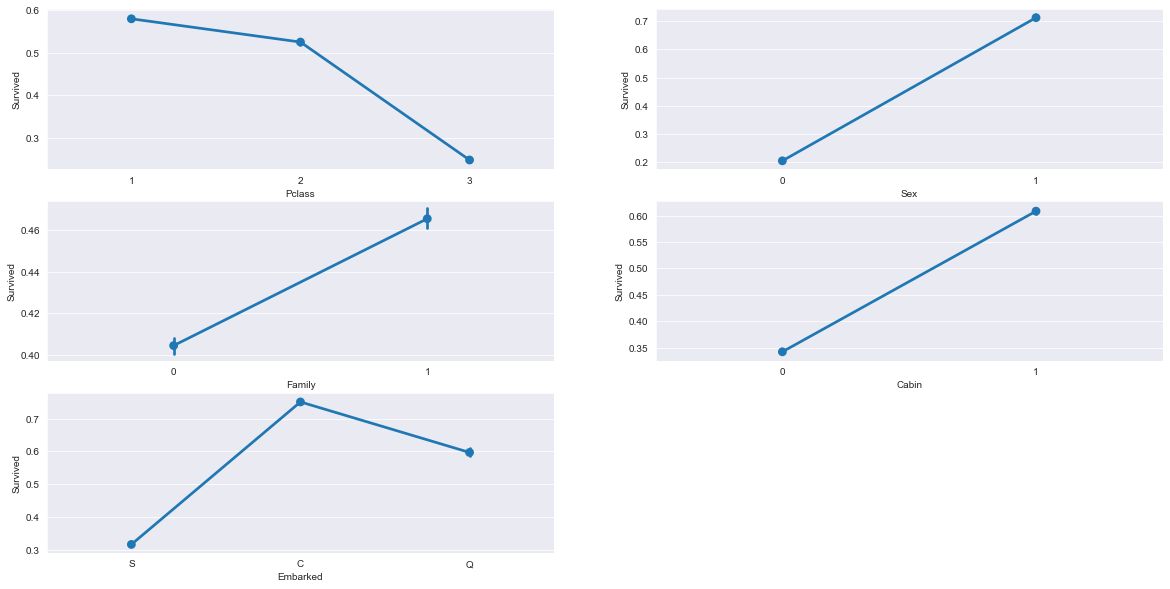

In [42]:
plt.figure(figsize=(20, 10))
colum = ['Pclass', 'Sex', 'Family', 'Cabin', 'Embarked']
for i, col in enumerate(colum,  1):
    plt.subplot(3,2,i)
    sns.pointplot(x=data_train[col], y=data_train['Survived'])

Мы можем наблюдать наличие сильных связей между категориальными переменными и целевым признаком. Рассмотрим данные признаки более подробно.

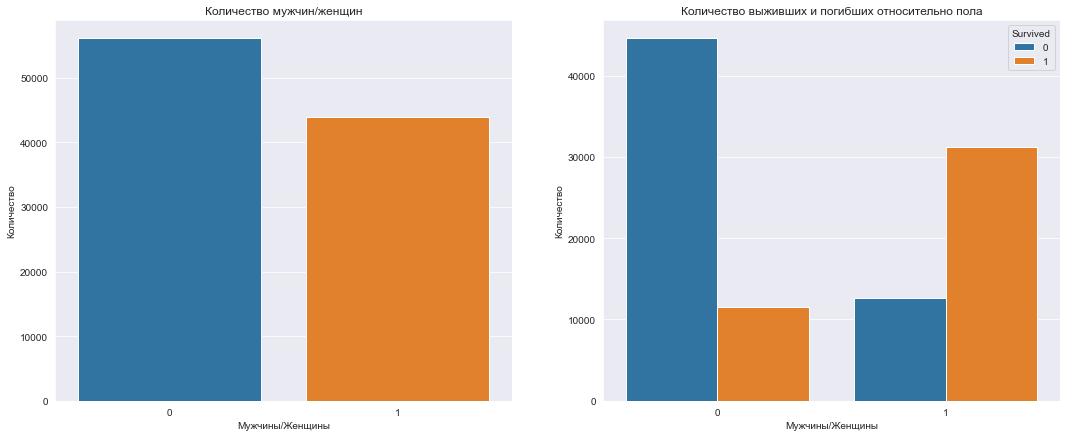

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(18,7))
sns.countplot(x=data_train['Sex'], ax=ax[0]).set_title("Количество мужчин/женщин")
ax[0].set(xlabel='Мужчины/Женщины', ylabel='Количество')
sns.countplot(x=data_train['Sex'], hue=data_train['Survived'], ax=ax[1]).set_title("Количество выживших и погибших относительно пола")
ax[1].set(xlabel='Мужчины/Женщины', ylabel='Количество')
plt.show()

In [44]:
quantity_male = data_train['Sex'].value_counts()[0]
quantity_female = data_train['Sex'].value_counts()[1]
print('Количество мужчин на корабле: ', quantity_male)
print('Количество женщин на корабле: ', quantity_female)

Количество мужчин на корабле:  56114
Количество женщин на корабле:  43886


In [45]:
print('% Выживших мужчин: ', data_train['Survived'][data_train['Sex']== 0].value_counts()[1]/quantity_male*100)
print('% Выживших женщин: ', data_train['Survived'][data_train['Sex']== 1].value_counts()[1]/quantity_female*100)

% Выживших мужчин:  20.579534519014864
% Выживших женщин:  71.15253155903933


На основании графиков и расчётов мы видим, что несмотря на то, что на борту 56.11% пассажиров были мужчины, процент выживших составляет всего 20.5 %. У женщин ситуация гораздо лучше, среди 43.89% женщин на борту выжило 71.15%.

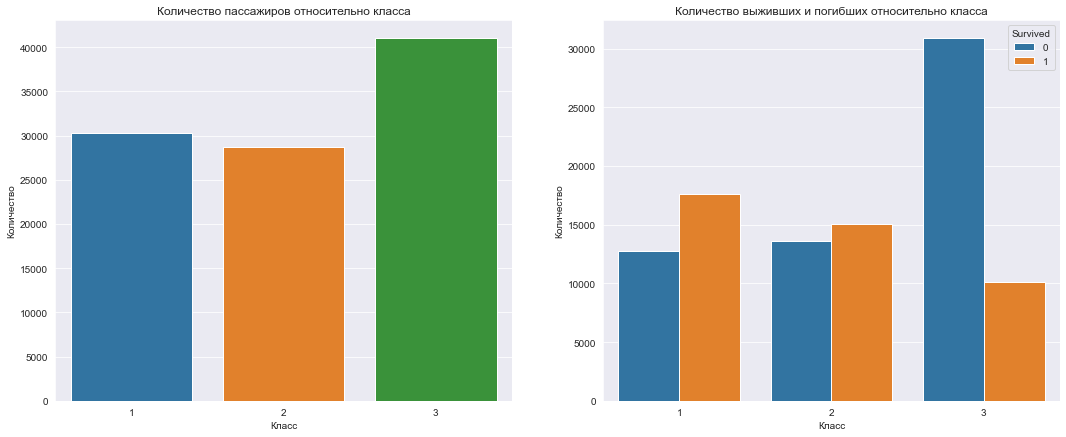

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(18,7))
sns.countplot(x=data_train['Pclass'], ax=ax[0]).set_title("Количество пассажиров относительно класса")
ax[0].set(xlabel='Класс', ylabel='Количество')
sns.countplot(x=data_train['Pclass'], hue=data_train['Survived'], ax=ax[1]).set_title("Количество выживших и погибших относительно класса")
ax[1].set(xlabel='Класс', ylabel='Количество')
plt.show()

In [47]:
data_train.groupby('Pclass').Survived.count()


Pclass
1    30315
2    28679
3    41006
Name: Survived, dtype: int64

In [48]:
data_train.groupby('Pclass').Survived.sum()

Pclass
1    17576
2    15057
3    10141
Name: Survived, dtype: int64

In [49]:
data_train.groupby('Pclass').Survived.sum()/data_train.groupby('Pclass').Survived.count()*100

Pclass
1    57.977899
2    52.501831
3    24.730527
Name: Survived, dtype: float64

Исходя из графиков и расчётов мы видим, что по 1 и 2 классу процент выживания составляет 57.9% и 52.5%. В 3 классе процент выживания составляет всего 24.73%, однако при этом наибольшее число пассажиров (41%) принадлежали 3 классу.

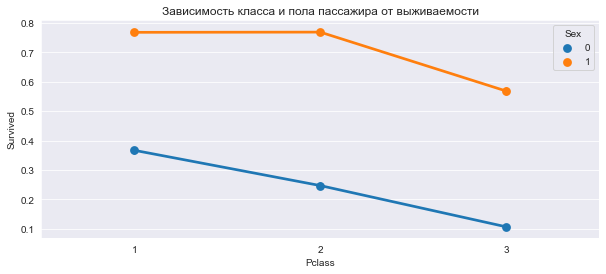

In [50]:
plt.figure(figsize=(10,4))
sns.pointplot(x=data_train['Pclass'], y=data_train['Survived'], hue=data_train['Sex']).set_title("Зависимость класса и пола пассажира от выживаемости")
plt.show()

Исходя из графика видно, что выживаемость мужчины сильно зависит от класса, которым он плывет. Самый низкий показатель выживаемости составляет 3 класс (около 10%). Выживаемость женщин во всех классах горазда больше, чем у мужчин. Так же видно, что выживаемость женщин в 3 классе (около 60 %) отличается от 1 и 2 класса в которых показатели приблизительно равные (около 80%).

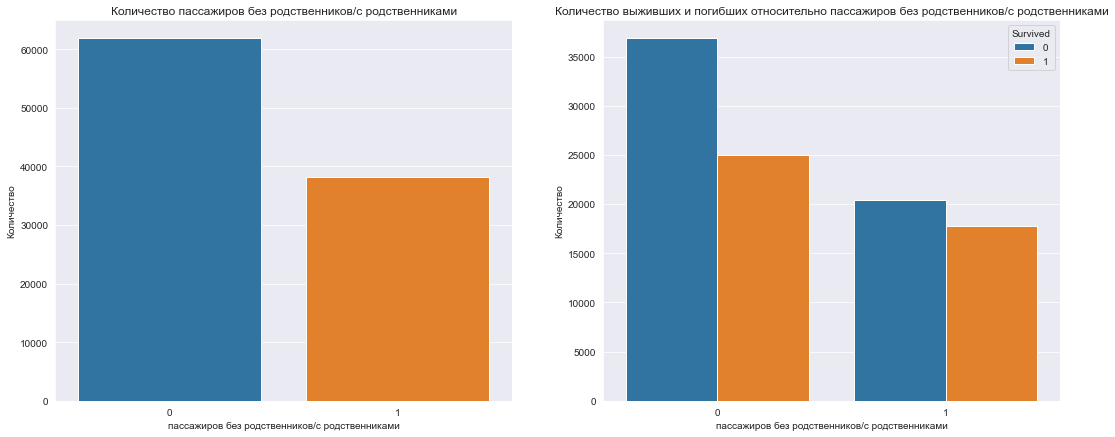

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(18,7))
sns.countplot(x=data_train['Family'], ax=ax[0]).set_title("Количество пассажиров без родственников/с родственниками")
ax[0].set(xlabel='пассажиров без родственников/с родственниками', ylabel='Количество')
sns.countplot(x=data_train['Family'], hue=data_train['Survived'], ax=ax[1]).set_title("Количество выживших и погибших относительно пассажиров без родственников/с родственниками")
ax[1].set(xlabel='пассажиров без родственников/с родственниками', ylabel='Количество')
plt.show()

In [52]:
data_train.groupby('Family').Survived.count()

Family
0    61853
1    38147
Name: Survived, dtype: int64

In [53]:
data_train.groupby('Family').Survived.sum()

Family
0    25013
1    17761
Name: Survived, dtype: int64

In [54]:
data_train.groupby('Family').Survived.sum()/data_train.groupby('Family').Survived.count()*100

Family
0    40.439429
1    46.559362
Name: Survived, dtype: float64

На основании графиков и расчётов мы видим, что процент выживших среди пассажиров без родственников составляет 40.4%, а при наличии родственников 46.55%. Связь данного признака с вероятностью выживания не так однозначна.

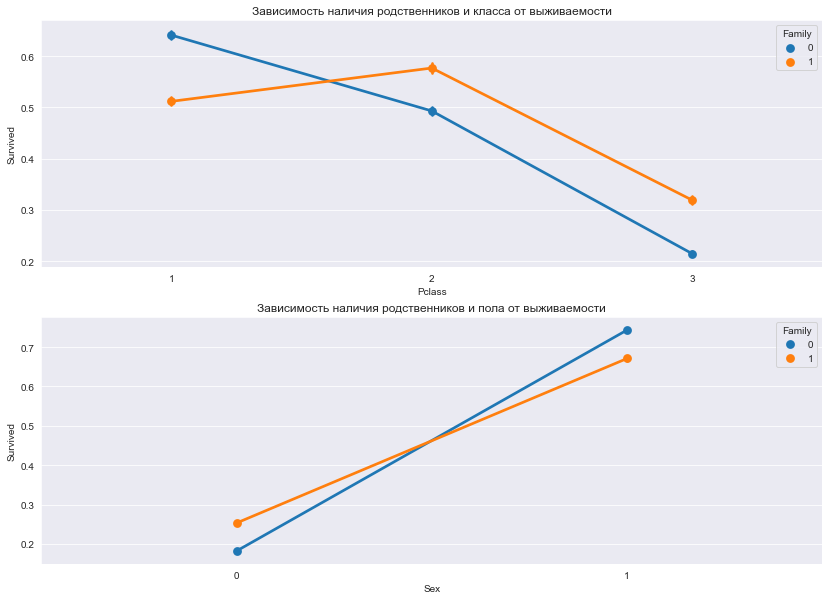

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(14,10))
sns.pointplot(x=data_train['Pclass'], y=data_train['Survived'], hue=data_train['Family'], ax=ax[0]).set_title("Зависимость наличия родственников и класса от выживаемости")
sns.pointplot(x=data_train['Sex'], y=data_train['Survived'], hue=data_train['Family'], ax=ax[1]).set_title("Зависимость наличия родственников и пола от выживаемости")
plt.show()

Исходя из графиков видно, что для пассажиров 1 класса вероятность выжить была больше, при отсутствии родственников. А для пассажиров 2 и 3 класса наоборот при наличии родственников.

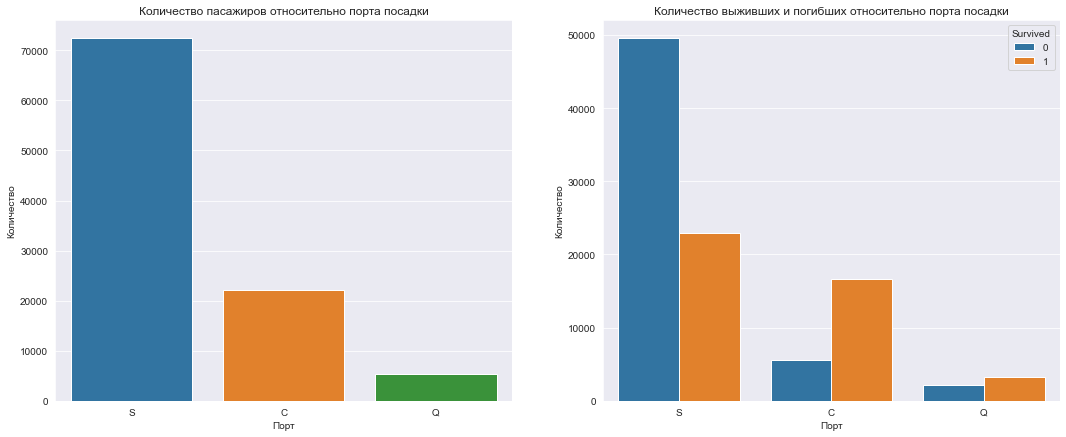

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(18,7))
sns.countplot(x=data_train['Embarked'], ax=ax[0]).set_title("Количество пасажиров относительно порта посадки")
ax[0].set(xlabel='Порт', ylabel='Количество')
sns.countplot(x=data_train['Embarked'], hue=data_train['Survived'], ax=ax[1]).set_title("Количество выживших и погибших относительно порта посадки")
ax[1].set(xlabel='Порт', ylabel='Количество')
plt.show()

In [57]:
data_train.groupby('Embarked').Survived.count()

Embarked
C    22187
Q     5424
S    72389
Name: Survived, dtype: int64

In [58]:
data_train.groupby('Embarked').Survived.sum()

Embarked
C    16669
Q     3238
S    22867
Name: Survived, dtype: int64

In [59]:
data_train.groupby('Embarked').Survived.sum()/data_train.groupby('Embarked').Survived.count()*100

Embarked
C    75.129580
Q    59.697640
S    31.589054
Name: Survived, dtype: float64

Мы видим, что наибольшее количество пассажиров (72.38%) садились в порту Саутгемптон (S), из которых выжило 31%. Это связано с тем, что пассажиров плывших на корабле из порта Саутгемптон (S) 3 классом составляло около 36% от всех пассажиров. При этом основную часть из них составляли мужчины (около 70%). А как мы выяснили ранее наименьший процент выживания был у мужчин плывших 3 классом.

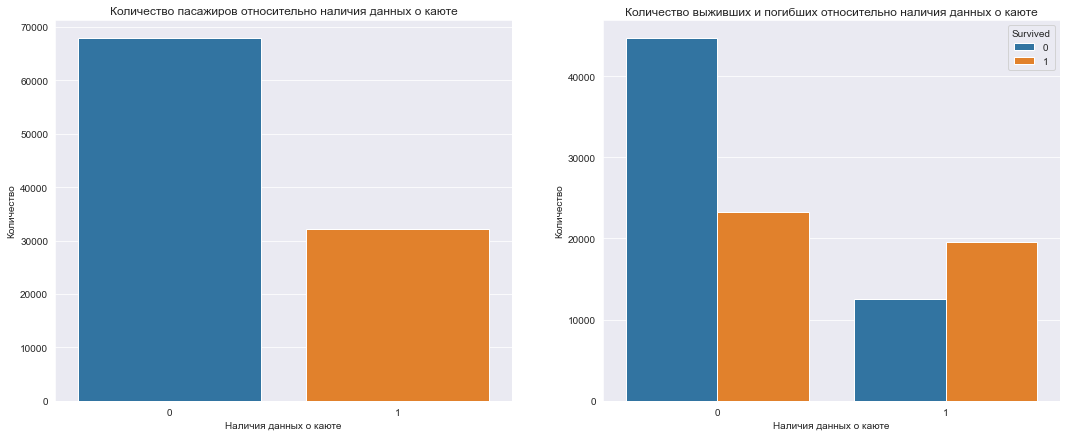

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(18,7))
sns.countplot(x=data_train['Cabin'], ax=ax[0]).set_title("Количество пасажиров относительно наличия данных о каюте")
ax[0].set(xlabel='Наличия данных о каюте', ylabel='Количество')
sns.countplot(x=data_train['Cabin'], hue=data_train['Survived'], ax=ax[1]).set_title("Количество выживших и погибших относительно наличия данных о каюте")
ax[1].set(xlabel='Наличия данных о каюте', ylabel='Количество')
plt.show()

Как мы и говорили ранее, что пассажиры чьи данные о каюте отсутствовали выжили в 34% случае, а у которых данные присутствовали выжили в 61% случае. Посмотрим взаимосвязь от других признаков.

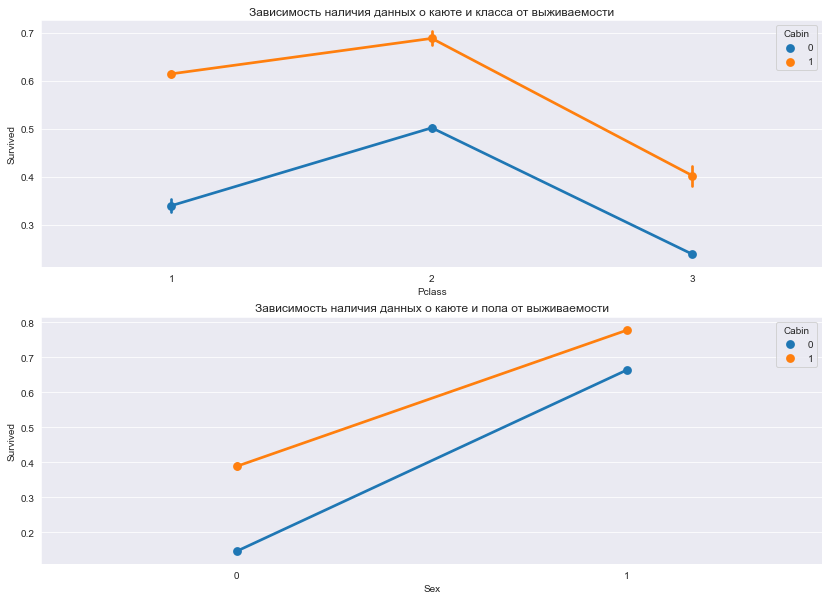

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(14,10))
sns.pointplot(x=data_train['Pclass'], y=data_train['Survived'], hue=data_train['Cabin'], ax=ax[0]).set_title("Зависимость наличия данных о каюте и класса от выживаемости")
sns.pointplot(x=data_train['Sex'], y=data_train['Survived'], hue=data_train['Cabin'], ax=ax[1]).set_title("Зависимость наличия данных о каюте и пола от выживаемости")
plt.show()

Исходя из графика видно, что выживаемость пассажиров с данными о каюте выше, по отношению к пассажирам без данных, вне зависимости от пола и класса пассажира.

#### Произведем корреляционный анализ

Построим матрицу корреляций между признаками.

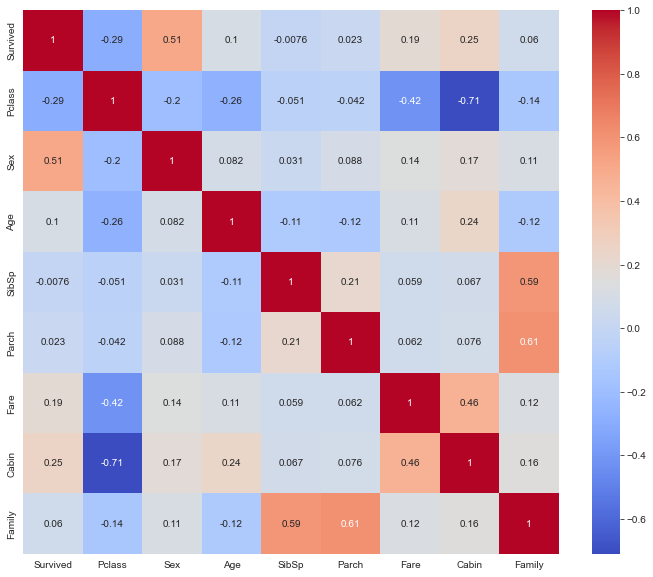

In [62]:
plt.figure(figsize=(12,10))
sns.heatmap(data_train.corr(), annot = True, cmap= 'coolwarm' )
plt.show()

Как видно из матрицы корреляций, наибольшая корреляция присутствует между целевым признаком 'Survived' и полом 'Sex' (0.51). Так же можно отметить наличие следующих небольших корреляций :
* между целевым признаком 'Survived' и каютой 'Sex' (0.25).
* между целевым признаком 'Survived' и цена билета 'Sex' (0.19).
* отрицательная корреляция между целевым признаком 'Survived' и классом 'Pclass'(-0.29).


# Summary

В данной работе мы произвели анализ и оценку возможности использования признаков, представленных в наборе данных о пассажирах Титаника. В результате чего сделали следующие выводы:
1) Исходный датасет содержит 4 количественных и 8 категориальных переменных. 

2) Для построения обучающей модели нецелесообразно использовать следующие признаки:
   * Индентификатор пассажира 'PassengerId';
   * Имя пассажира 'Name';
   * Номер билета 'Ticket';
   
   Признаки 'Name', 'Ticket', 'PassengerId’ является уникальными для всех. 
   
3) В признаке 'Cabin' отсутствие данных составляет 67%. Поэтому данный признак целесообразно удалить или заменить другим признаком как мы сделали в данной работе.

4) Для признаков 'Age' и 'Ticket' необходимо устранить отсутствие данных, так как пропуск составляет менее 3%.

5) Признаки 'SibSp' и 'Parch' имеют кошенные распределения. Количество пассажиров, у которых не было родственников на борту составляет более 70%. Это приводит к дисбалансу классов, что может отрицательно сказаться на обучающую модель. Для снижения дисбаланса мы создали новую переменную 'Family'.

6) Все категориальные признаки которые мы оставили для дальнейшего анализа показали наличие связи с целевым признаком 'Survived'.

7) Признак 'Sex' обладает наиболее высоким прогностическим эффектом.

8) Среди женщин наблюдается намного больший процент выживших - 71% , по сравнению с мужчинами-20%, т.е. среди погибших почти 80% - мужчины.

8) Наименьшая вероятность выжить была у мужчин в возрастном диапазоне от 20 до 40 лет плывущими 3 классом, которые садились в порту Саутгемптон (S) не имеющих данных о билетах и родственников на борту.
